# Исследование сервиса аренды самокатов GoFast

Цель проекта: Проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

План работы:
1. Загрузка данных.
2. Предобработка данных.
3. Исследовательский анализ данных.
4. Объединение данных.
5. Подсчёт выручки.
6. Проверка гипотез.
7. Распределения.
8. Общий вывод.

Введение: Я аналитик популярного сервиса аренды самокатов GoFast. Мне передали данные о некоторых пользователях из нескольких городов, а также об их поездках.

Описание данных:
В основных данных есть информация о пользователях, их поездках и подписках.

1. Датафрейм пользователи — users_go.csv
2. Датафрейм поездки — rides_go.csv
3. Датафрейм подписки — subscriptions_go.csv

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
from math import factorial
from math import sqrt
from scipy.stats import binom, norm
from scipy import stats as st

## Загрузка данных

In [2]:
users = pd.read_csv('users_go.csv')
print(users.info())
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [3]:
rides = pd.read_csv('rides_go.csv')
print(rides.info())
rides.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [4]:
subscriptions = pd.read_csv('subscriptions_go.csv')
print(subscriptions.info())
subscriptions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Вывел первые строки каждого набора данных. Изучил общую информацию о каждом датафрейме.

## Предобработка данных

In [5]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%dT%H:%M:%S')

In [6]:
rides['month'] = rides['date'].dt.month
rides['date'].dt.year.unique()

array([2021], dtype=int64)

In [7]:
print(users.duplicated().sum(),rides.duplicated().sum(),subscriptions.duplicated().sum())

31 0 0


In [8]:
users = users.drop_duplicates()

Привел столбец date к типу даты pandas. Создал новый столбец с номером месяца на основе столбца date. Убедился, что в датафрейме данные только за 2021 год. Проверил наличие пропущенных значений и дубликатов в датафреймах. Пропущенных значений нет. Нашел 31 дупликат в датафрейме users. Удалил дупликаты.

## Исследовательский анализ данных

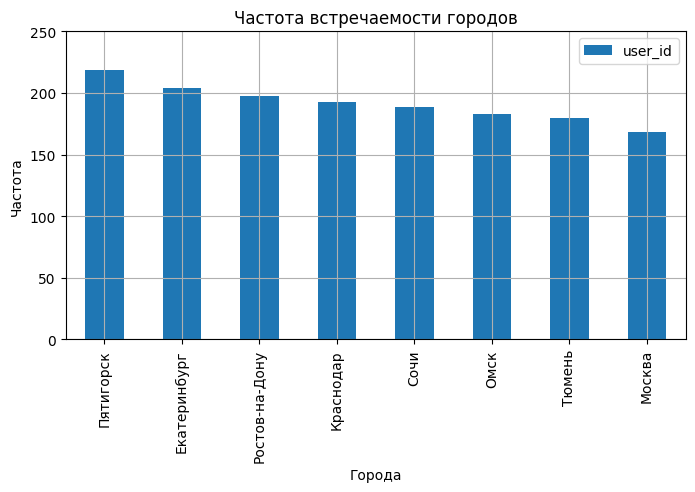

In [9]:
users.pivot_table(index='city', values='user_id', aggfunc='count').sort_values('user_id', ascending=False).plot(
    kind='bar', grid=True, figsize=(8, 4), ylim=(0, 250))
plt.title('Частота встречаемости городов')
plt.xlabel('Города')
plt.ylabel('Частота')
plt.legend(loc="upper right");

Сделал график частоты встречаемости городов. Большего всего пользователей в Пятигорске, меньше всего в Москве.

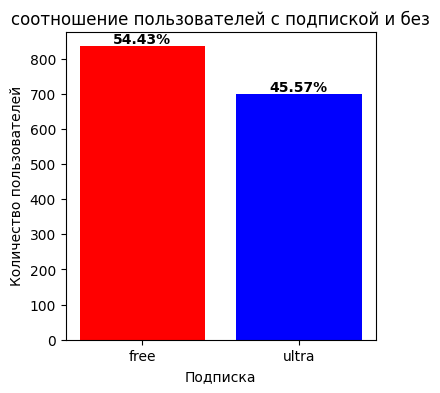

In [10]:
#Создаю таблицу по которой буду строить график
users_percentage = users.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
#Добавляем столбец с долями
total_users = users.shape[0]
percentage = []
for i in range(users_percentage.shape[0]):
    pct = (users_percentage.user_id[i] / total_users) * 100
    percentage.append(round(pct,2))
users_percentage['Percentage'] = percentage
#Отобразим график
plt.figure(figsize=(4, 4))
colors_list = ['Red', 'Blue']
graph = plt.bar(users_percentage.index, users_percentage.user_id, color = colors_list)
plt.title('соотношение пользователей с подпиской и без')
plt.xlabel('Подписка')
plt.ylabel('Количество пользователей')
i = 0
#Добавим на график доли в процентах на каждый столбик 
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(users_percentage.Percentage[i])+'%', ha='center', weight='bold')
    i+=1
plt.show()

На этом графике сравнил количество пользователей с подпиской и без. Пользователей с подпиской меньше.

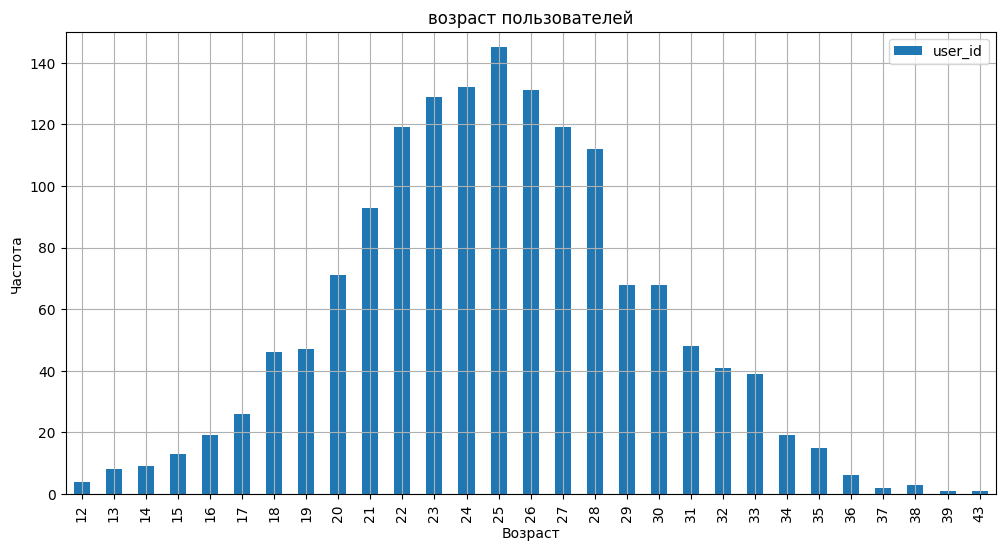

In [11]:
users.pivot_table(index='age', values='user_id', aggfunc='count').sort_values(by='age', ascending=True).plot(
    kind='bar', grid=True, figsize=(12, 6), ylim=(0, 150))
plt.title('возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.legend(loc="upper right");

На этом графике визуализировал количество пользователей по возрасту. Самокатами пользуются люди от 12 до 43 лет. Близко к нормальному распределению с центром в возрасте 25 лет.

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

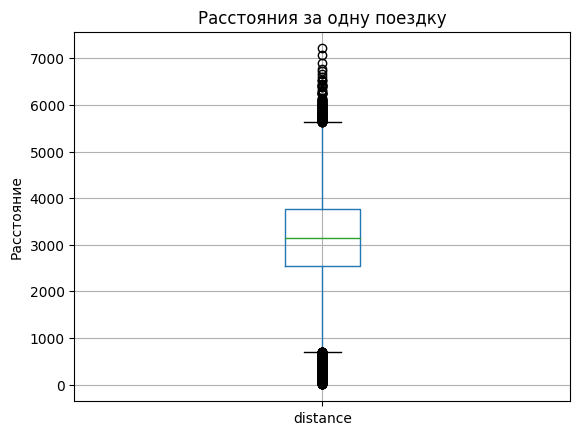

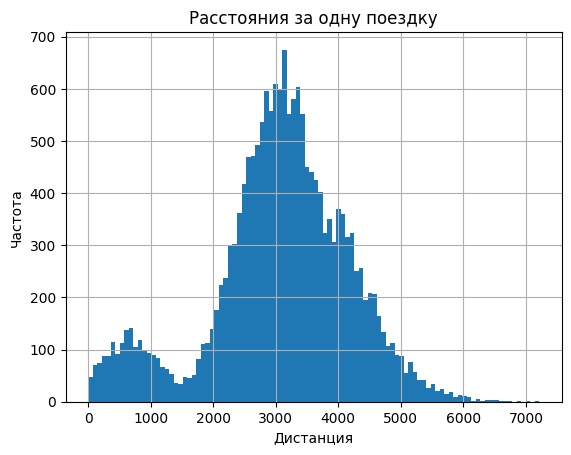

In [12]:
rides.boxplot('distance')
plt.title('Расстояния за одну поездку')
plt.ylabel('Расстояние')
rides.hist('distance', bins=100)
plt.title('Расстояния за одну поездку')
plt.xlabel('Дистанция')
plt.ylabel('Частота')
rides['distance'].describe()

Большая часть поездок было совершено на расстояние от 2500 км до 3800 км. Максимум в районе 3200 км

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

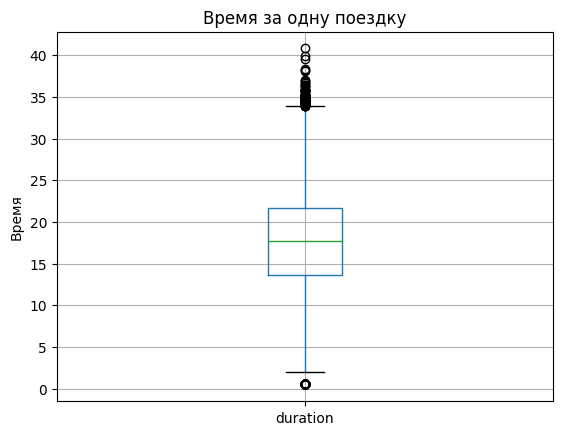

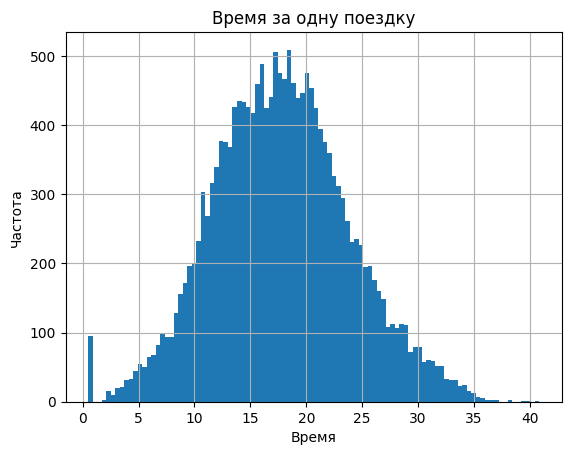

In [13]:
rides.boxplot('duration')
plt.title('Время за одну поездку')
plt.ylabel('Время')
rides.hist('duration', bins=100)
plt.title('Время за одну поездку')
plt.xlabel('Время')
plt.ylabel('Частота')
rides['duration'].describe()

Большая часть поездок занимает время от 13 мин до 22 мин. Максимум в районе 17 мин. Вижу небольшое количество аномальных значений в начале гистограммы.

## Объединение данных

In [14]:
full_data = users.merge(rides, on='user_id').merge(subscriptions, on='subscription_type')
full_data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [15]:
full_data_ultra = full_data.query('subscription_type == "ultra"')
full_data_free = full_data.query('subscription_type == "free"')

In [16]:
full_data_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [17]:
full_data_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


Text(0, 0.5, 'Частота')

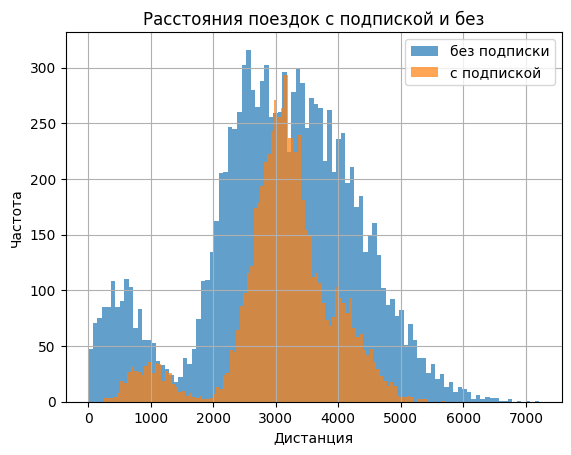

In [18]:
ax = full_data_free.plot(kind='hist', y='distance', bins=100, linewidth=5,
    alpha=0.7, label='без подписки')
full_data_ultra.plot(kind='hist', y='distance', bins=100, linewidth=5,
    alpha=0.7, label='с подпиской', ax=ax, grid=True, legend=True) 
plt.title('Расстояния поездок c подпиской и без')
plt.xlabel('Дистанция')
plt.ylabel('Частота')

Text(0, 0.5, 'Частота')

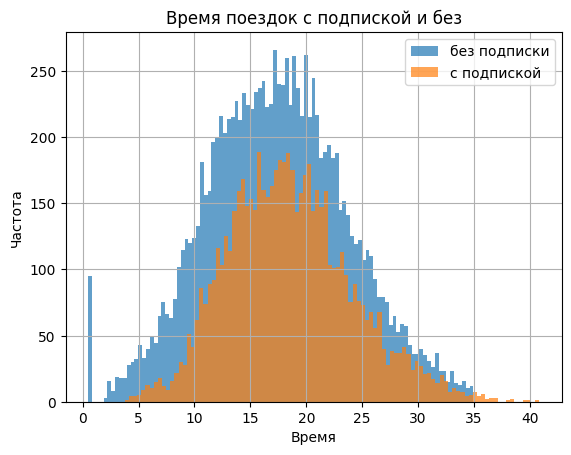

In [19]:
ax = full_data_free.plot(kind='hist', y='duration', bins=100, linewidth=5,
    alpha=0.7, label='без подписки')
full_data_ultra.plot(kind='hist', y='duration', bins=100, linewidth=5,
    alpha=0.7, label='с подпиской', ax=ax, grid=True, legend=True) 
plt.title('Время поездок с подпиской и без')
plt.xlabel('Время')
plt.ylabel('Частота')

Объединил данные о пользователях, поездках и подписках в один датафрейм.

Создал ещё два датафрейма:
c данными о пользователях без подписки;
с данными о пользователях с подпиской.

Отобразил распределение расстояний и времени для двух новых датофреймов.

## Подсчёт выручки

In [20]:
pd.options.mode.chained_assignment = None
full_data['duration'] = np.ceil(full_data['duration'])

Было предупреждение: цепное присваивания в Pandas. Погуглил. Подавил.

In [21]:
data_profit = full_data.pivot_table(
    index=['user_id', 'month'], values='distance', aggfunc='sum'
)
data_profit['rides_count'] = full_data.pivot_table(
    index=['user_id', 'month'], values='distance', aggfunc='count'
)
data_profit['duration'] = full_data.pivot_table(
    index=['user_id', 'month'], values='duration', aggfunc='sum'
)
data_profit

distance  rides_count  duration
user_id month                                     
1       1       7027.511294            2      42.0
        4        754.159807            1       7.0
        8       6723.470560            2      46.0
        10      5809.911100            2      32.0
        11      7003.499363            3      56.0
...                     ...          ...       ...
1534    6       3409.468534            2      26.0
        8       7622.453034            2      48.0
        9       4928.173852            1      23.0
        11     13350.015305            4      78.0
        12      2371.711192            1      16.0

[11331 rows x 3 columns]

In [22]:
data_profit['start_ride_price'] = full_data.pivot_table(
    index=['user_id', 'month'], values='start_ride_price', aggfunc='sum'
)
data_profit['subscription_fee'] = full_data.pivot_table(
    index=['user_id', 'month'], values='subscription_fee', aggfunc='first'
)
data_profit['minute_price'] = full_data.pivot_table(
    index=['user_id', 'month'], values='minute_price', aggfunc='first'
)
data_profit['profit'] = data_profit['start_ride_price'] + data_profit['subscription_fee'] + data_profit['duration']*data_profit['minute_price']
data_profit

distance  rides_count  duration  start_ride_price  \
user_id month                                                          
1       1       7027.511294            2      42.0                 0   
        4        754.159807            1       7.0                 0   
        8       6723.470560            2      46.0                 0   
        10      5809.911100            2      32.0                 0   
        11      7003.499363            3      56.0                 0   
...                     ...          ...       ...               ...   
1534    6       3409.468534            2      26.0               100   
        8       7622.453034            2      48.0               100   
        9       4928.173852            1      23.0                50   
        11     13350.015305            4      78.0               200   
        12      2371.711192            1      16.0                50   

               subscription_fee  minute_price  profit  
user_id month                                          
1       1                   199             6   451.0  
        4                   199             6   241.0  
        8                   199             6   475.0  
        10                  199             6   391.0  
        11                  199             6   535.0  
...                         ...           ...     ...  
1534    6                     0             8   308.0  
        8                     0             8   484.0  
        9                     0             8   234.0  
        11                    0             8   824.0  
        12                    0             8   178.0  

[11331 rows x 7 columns]

Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляем до следующего целого числа. 

Создал датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными.

В этот же датафрейм добавил столбец с помесячной выручкой, которую принёс каждый пользователь.

## Проверка гипотез

Задача 1. Важно понять, тратят ли пользователи с подпиской больше времени на поездки?

Нулевая гипотеза: Пользователи с подпиской тратят столько же времени сколько и пользователи без подписки или меньше .

Альтернативную гипотеза: Пользователи с подпиской тратят больше времени на поездки.

In [23]:
alpha = 0.05
results = st.ttest_ind(full_data_ultra['duration'], full_data_free['duration'], alternative='greater')
print(f'p-value: {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.2804098316645613e-34
Отвергаем нулевую гипотезу


Ответ: Пользователи с подпиской тратят больше времени на поездки.

Задача 2. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метро?

Нулевая гипотеза: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

Альтернативную гипотеза: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров

In [24]:
interested_value = 3130
alpha = 0.05 
results = st.ttest_1samp(
    full_data_ultra['distance'], 
    interested_value,
    alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Ответ: Можно сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

Задача 3. Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Нулевая гипотеза: Помесячная выручка от пользователей с подпиской по месяцам не выше, чем выручка от пользователей без подписки.

Альтернативную гипотеза: Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

In [25]:
data_profit_ultra = data_profit.query('start_ride_price == 0')
data_profit_free = data_profit.query('start_ride_price > 0')

In [26]:
alpha = 0.05
results = st.ttest_ind(data_profit_ultra['profit'], data_profit_free['profit'], alternative='greater')
print(f'p-value: {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Ответ: Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Задача 4. Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Нулевая гипотеза: количество обращений в техподдержку не изменилось

Альтернативную гипотеза: количество обращений в техподдержку снизилось.

Ответ: Мне понадобится тест scipy.stats.st.ttest_rel и набор данных до и после с арггументом alternative='less'

## Распределения

<b>Задача 1. 

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

0.04976090094990486

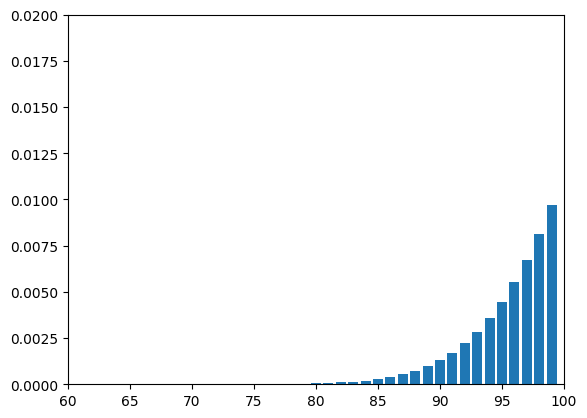

In [27]:
p = 0.1
n = 1161
distr = []
plan = 0
for k in range(0, 100):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1-p)**(n-k) 
    distr.append(prob)
    plan += prob
plt.ylim(0, 0.02)
plt.xlim(60, 100)     
plt.bar(range(0, 100), distr)
plan

Ответ: Я применил счетчик к методу построения биномального распределения. С помощью подбора количества купонов выяснил что при 1161 промокодов  вероятность не выполнить план будет примерно 5 %.

<b>Задача 2.

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

0.15371708296369768

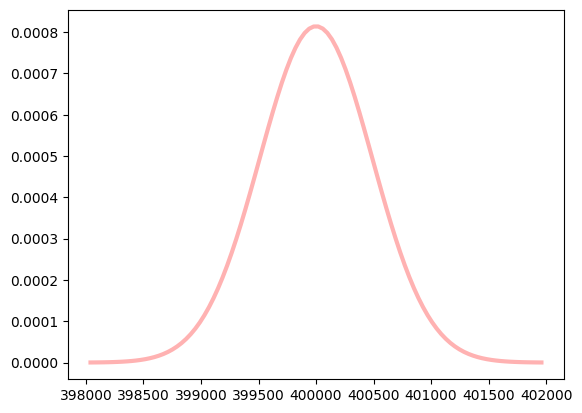

In [28]:
# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
# задаём параметры биномиального распределения
n = 1000000
p = 0.4
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
# границы промежутка, в котором будем строить аппроксимацию -
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
ax = plt.subplot()
# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 3 и прозрачности 0.3
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3)
#оценим вероятность
distr = st.norm(mu, sigma) 
distr.cdf(399500)

Условием хорошей аппроксимации является большое число n и условием аппроксимации часто считают p, близкое к 0.5. В нашем случае аппроксимация будет практически идеальна. Воспользуемся нормальной аппроксимацией биномиального распределения и cdf() для быстрой оценки. 

Построил примерный график распределения.

Ответ: Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей будет примерно 15%.



## Общий вывод.

Вывел первые строки каждого набора данных. Изучил общую информацию о каждом датафрейме.
Осуществил предобработку данных. 
Провел исследовательский анализ данных. Были изучены параметры датафреймов.
Подготовил данные для проверки гипотез. Отобразил распределения дистанции и времени для пользователей с подпиской и без. Было найдено необольшое количество аномальные значений в столбце с информацией о времени. 
Выделил информацию с помесячной выручкой, которую принёс каждый пользователь.

Проверил гипотезы.
Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов:

1. Важно понять, тратят ли пользователи с подпиской больше времени на поездки?

Ответ: Пользователи с подпиской тратят больше времени на поездки.

2. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Ответ: Можно сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

3. Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Ответ: Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

4. Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Ответ: Мне понадобится тест scipy.stats.st.ttest_rel и набор данных до и после с арггументом alternative='less'

Также ответил на задачи от дела маркетинга.

1. Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Ответ: Я применил счетчик к методу построения биномального распределения. С помощью подбора количества купонов выяснил что при 1161 промокодов вероятность не выполнить план будет примерно 5 %.

2. Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Ответ: Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей будет примерно 15%.